In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import joblib
from sklearn.model_selection import TimeSeriesSplit
import optuna 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def clean_column_names(df):
    """Clean column names to be compatible with XGBoost"""
    df = df.copy()
    # Remove brackets and clean special characters
    df.columns = (df.columns
                 .str.replace('[', '')
                 .str.replace(']', '')
                 .str.replace(' ', '_')
                 .str.replace('(', '')
                 .str.replace(')', '')
                 .str.replace('ö', 'oe')  # Handle German special characters
                 .str.replace('ä', 'ae')
                 .str.replace('ü', 'ue'))
    return df

def create_lagged_features(df, target_col, lag_hours=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 24, 48, 72, 168, 336, 672, 1008, 2016, 8760]):
    """Create additional lagged features for time series data"""
    df_copy = df.copy()
    
    # Create lags for a variety of time periods (e.g., 1h, 2h, 1 day, 1 week, etc.)
    for lag in lag_hours:
        df_copy[f'{target_col}_lag_{lag}h'] = df_copy[target_col].shift(lag)
        
    # Drop rows with NaN values created by lagging
    df_copy = df_copy.dropna()
    
    return df_copy


def preprocess_load_data(data, split_date='2023-09-30'):
    """Preprocess the load data including lagged features"""
    # Create a copy of the data
    df = data.copy()
    
    # Store the original load column name
    original_load_col = 'Gesamt (Netzlast) [MWh] Berechnete Auflösungen'
    
    # Convert Date column to datetime and sort
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    
    # Create lagged features before cleaning column names
    df = create_lagged_features(df, target_col=original_load_col)
    
    # Clean column names
    df = clean_column_names(df)
    
    # Get the cleaned load column name
    load_col = 'Gesamt_Netzlast_MWh_Berechnete_Aufloesungen'
    
    # Rename to 'load'
    df = df.rename(columns={load_col: 'load'})
    
    # Select features for the model (using cleaned names)
    base_features = [
        'hour', 'dayofyear_cos', 'dayofweek', 'dayofweek_sin',
        'is_workday', 'hour_cos', 'date_offset', 'dayofyear',
        'Kernenergie_MWh_Berechnete_Aufloesungen',
        'Steinkohle_MWh_Berechnete_Aufloesungen',
        'Holiday_Not_a_Holiday', 'hour_sin',
        'Wind_Onshore_MWh_Berechnete_Aufloesungen'
    ]
    
    # Add lagged feature names
    lag_features = [col for col in df.columns if 'lag' in col]
    feature_columns = base_features + lag_features
    
    # Split data based on date
    train_data = df[df['Date'] < split_date]
    test_data = df[df['Date'] >= split_date]
    
    # Split features and target
    X_train = train_data[feature_columns]
    y_train = train_data['load']
    X_test = test_data[feature_columns]
    y_test = test_data['load']
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert back to pandas DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)
    
    print(f"\nTraining data shape: {X_train_scaled.shape}")
    print(f"Testing data shape: {X_test_scaled.shape}")
    print(f"Training period: {train_data['Date'].min()} to {train_data['Date'].max()}")
    print(f"Testing period: {test_data['Date'].min()} to {test_data['Date'].max()}")
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_columns

In [ ]:
def evaluate_models_cv(X_train, y_train, n_folds=5):
    """Evaluate multiple models using cross-validation on training data"""
    
    # Define base models with default parameters
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=1500,
            learning_rate=0.01,
            max_depth=20,
            random_state=42
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=3000,
            learning_rate=0.05,
            max_depth=35,
            random_state=42
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=30,
            max_depth=25,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nEvaluating {name} using {n_folds}-fold cross-validation...")
        
        # Perform cross-validation for MAPE
        mape_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=n_folds,
            scoring='neg_mean_absolute_percentage_error',
            n_jobs=-1  # Use all available cores
        )
        
        # Convert negative MAPE scores to positive percentages
        mape_scores = -mape_scores * 100
        
        # Perform cross-validation for MAE
        mae_scores = cross_val_score(
            model,
            X_train,
            y_train,
            cv=n_folds,
            scoring='neg_mean_absolute_error',
            n_jobs=-1  # Use all available cores
        )
        
        # Convert negative MAE scores to positive values
        mae_scores = -mae_scores
        
        # Store results
        results[name] = {
            'cv_mape_scores': mape_scores,
            'mean_cv_mape': mape_scores.mean(),
            'std_cv_mape': mape_scores.std(),
            'cv_mae_scores': mae_scores,
            'mean_cv_mae': mae_scores.mean(),
            'std_cv_mae': mae_scores.std()
        }
        
        print(f"{name} Results:")
        print(f"Mean CV MAPE: {mape_scores.mean():.2f}% (±{mape_scores.std():.2f})")
        print(f"Individual fold MAPEs: {[f'{score:.2f}%' for score in mape_scores]}")
        print(f"Mean CV MAE: {mae_scores.mean():.2f} (±{mae_scores.std():.2f})")
        print(f"Individual fold MAEs: {[f'{score:.2f}' for score in mae_scores]}")
    
    return results

In [5]:
# Load the data
df = pd.read_csv('../Data/selected_features.csv')

# Preprocess the data
X_train, X_test, y_train, y_test, feature_names = preprocess_load_data(df)


Training data shape: (34319, 34)
Testing data shape: (9541, 34)
Training period: 2019-10-31 18:00:00 to 2023-09-29 23:00:00
Testing period: 2023-09-30 00:00:00 to 2024-10-30 23:00:00


In [26]:
# Train and evaluate models
results = evaluate_models_cv(X_train, y_train)


Evaluating XGBoost using 5-fold cross-validation...
XGBoost Results:
Mean CV MAPE: 0.86% (±0.12)
Individual fold MAPEs: ['0.83%', '0.81%', '0.77%', '0.81%', '1.11%']
Mean CV MAE: 468.26 (±41.88)
Individual fold MAEs: ['451.37', '463.21', '446.07', '431.22', '549.45']

Evaluating LightGBM using 5-fold cross-validation...
LightGBM Results:
Mean CV MAPE: 0.75% (±0.09)
Individual fold MAPEs: ['0.72%', '0.70%', '0.67%', '0.71%', '0.93%']
Mean CV MAE: 406.96 (±30.49)
Individual fold MAEs: ['394.74', '405.03', '386.41', '382.67', '465.97']

Evaluating RandomForest using 5-fold cross-validation...
RandomForest Results:
Mean CV MAPE: 0.90% (±0.11)
Individual fold MAPEs: ['0.88%', '0.88%', '0.81%', '0.83%', '1.11%']
Mean CV MAE: 493.39 (±38.39)
Individual fold MAEs: ['484.05', '509.07', '468.30', '446.95', '558.58']


## Specific model: 

In [29]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate multiple models"""
    models = {
        'XGBoost': xgb.XGBRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            max_depth=30,
            random_state=42
        ),
        'LightGBM': lgb.LGBMRegressor(
            n_estimators=3000,
            learning_rate=0.05,
            max_depth=35,
            random_state=42
        ),
        'RandomForest': RandomForestRegressor(
            n_estimators=30,
            max_depth=25,
            random_state=42
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        # Calculate MAPE
        train_mape = mean_absolute_percentage_error(y_train, train_pred) * 100
        test_mape = mean_absolute_percentage_error(y_test, test_pred) * 100
        test_mae = mean_absolute_error(y_test, test_pred)

        
        results[name] = {
            'train_mape': train_mape,
            'test_mape': test_mape,
            'model': model
        }
        
        print(f"{name} Results:")
        print(f"Train MAPE: {train_mape:.2f}%")
        print(f"Test MAPE: {test_mape:.2f}%")
        print(f"Test MAE: {test_mae:.2f}")
    
    return results

In [30]:
# Train and evaluate models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)


Training XGBoost...
XGBoost Results:
Train MAPE: 0.00%
Test MAPE: 0.94%
Test MAE: 489.51

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6965
[LightGBM] [Info] Number of data points in the train set: 34319, number of used features: 34
[LightGBM] [Info] Start training from score 55789.419403
LightGBM Results:
Train MAPE: 0.28%
Test MAPE: 0.86%
Test MAE: 450.10

Training RandomForest...
RandomForest Results:
Train MAPE: 0.30%
Test MAPE: 0.99%
Test MAE: 515.27


In [ ]:
# Save models
# joblib.dump(results['XGBoost']['model'], 'xgboost_model.pkl')
# joblib.dump(results['LightGBM']['model'], 'lightgbm_model.pkl')
# joblib.dump(results['RandomForest']['model'], 'randomforest_model.pkl')

# # To load the models later:
# xgboost_model = joblib.load('xgboost_model.pkl')
# lightgbm_model = joblib.load('lightgbm_model.pkl')
# randomforest_model = joblib.load('randomforest_model.pkl')


['randomforest_model.pkl']

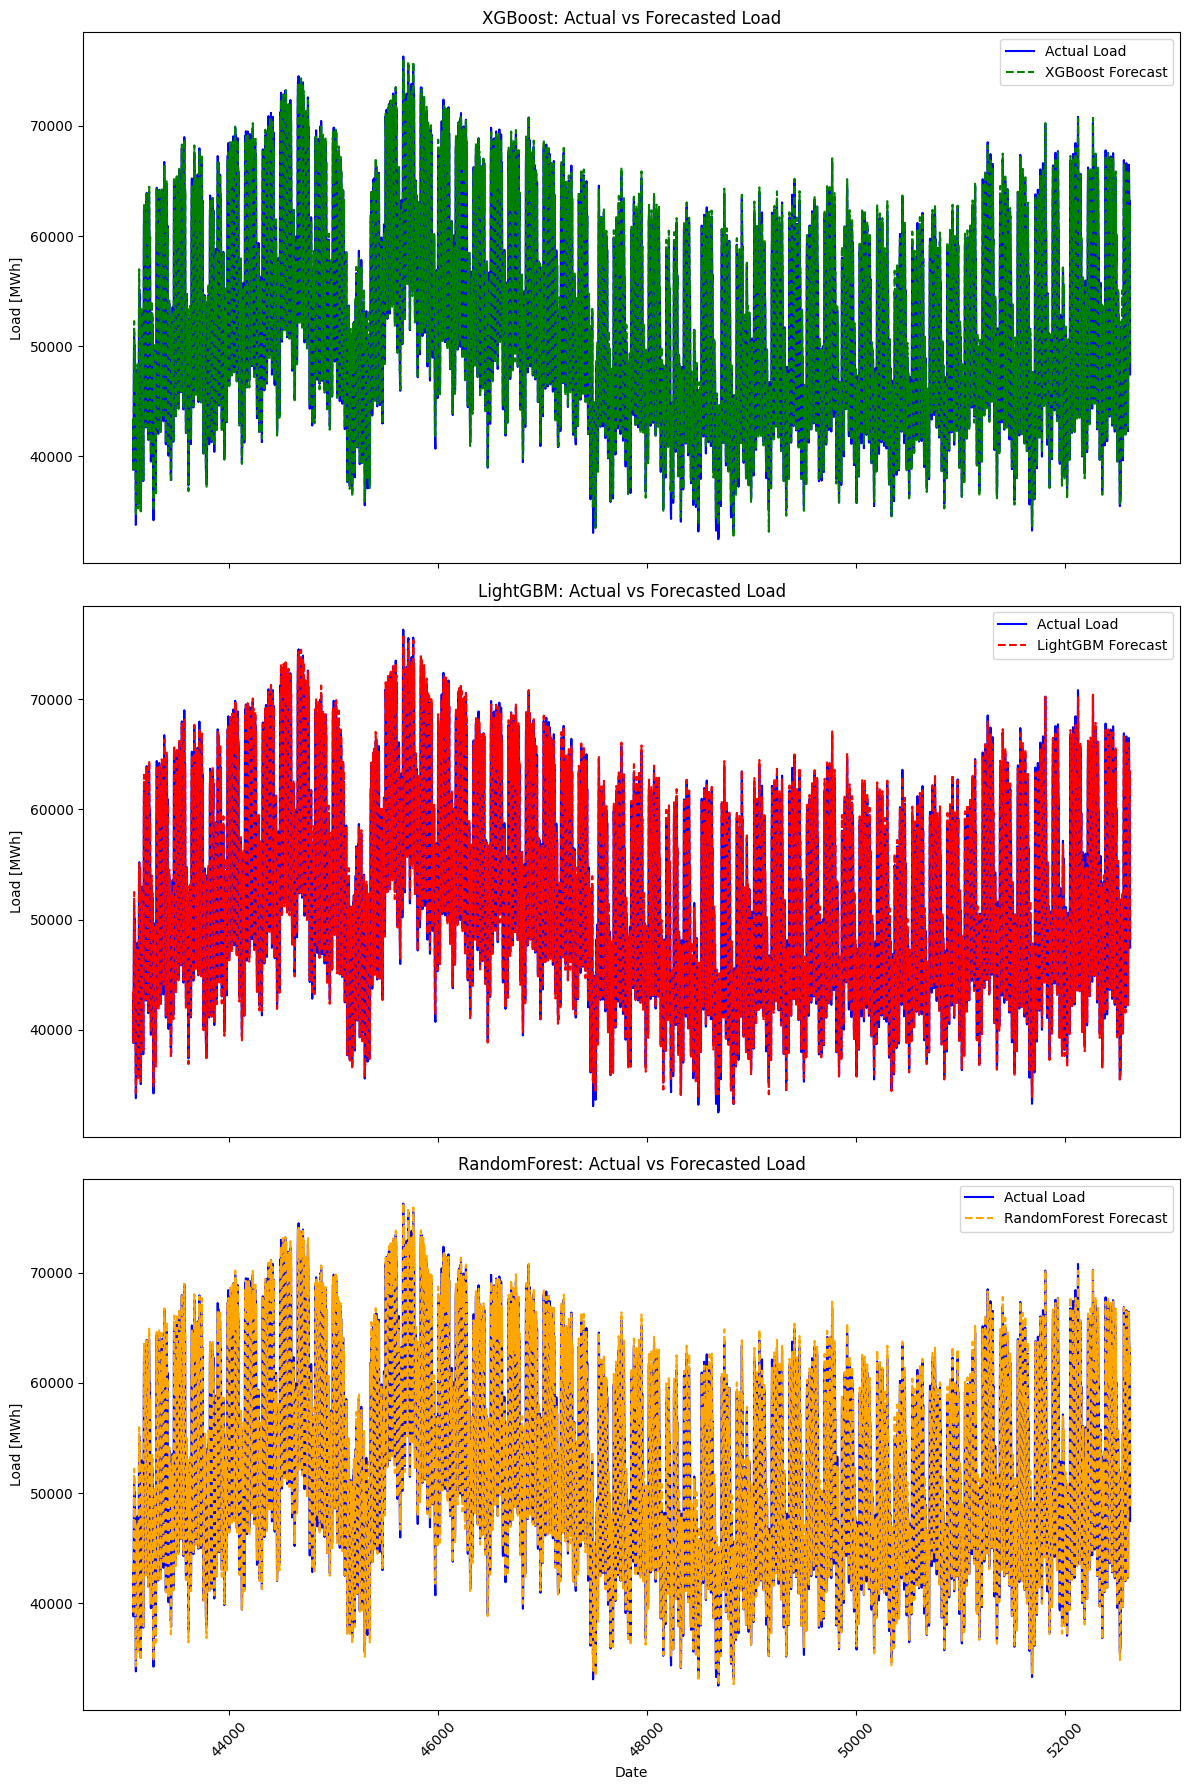

In [9]:
# Make predictions on the test set
xgboost_pred = results['XGBoost']['model'].predict(X_test)
lightgbm_pred = results['LightGBM']['model'].predict(X_test)
randomforest_pred = results['RandomForest']['model'].predict(X_test)

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# XGBoost plot
axes[0].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[0].plot(y_test.index, xgboost_pred, label='XGBoost Forecast', color='green', linestyle='--')
axes[0].set_title('XGBoost: Actual vs Forecasted Load')
axes[0].set_ylabel('Load [MWh]')
axes[0].legend()

# LightGBM plot
axes[1].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[1].plot(y_test.index, lightgbm_pred, label='LightGBM Forecast', color='red', linestyle='--')
axes[1].set_title('LightGBM: Actual vs Forecasted Load')
axes[1].set_ylabel('Load [MWh]')
axes[1].legend()

# RandomForest plot
axes[2].plot(y_test.index, y_test, label='Actual Load', color='blue')
axes[2].plot(y_test.index, randomforest_pred, label='RandomForest Forecast', color='orange', linestyle='--')
axes[2].set_title('RandomForest: Actual vs Forecasted Load')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Load [MWh]')
axes[2].legend()

# Display the plots
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


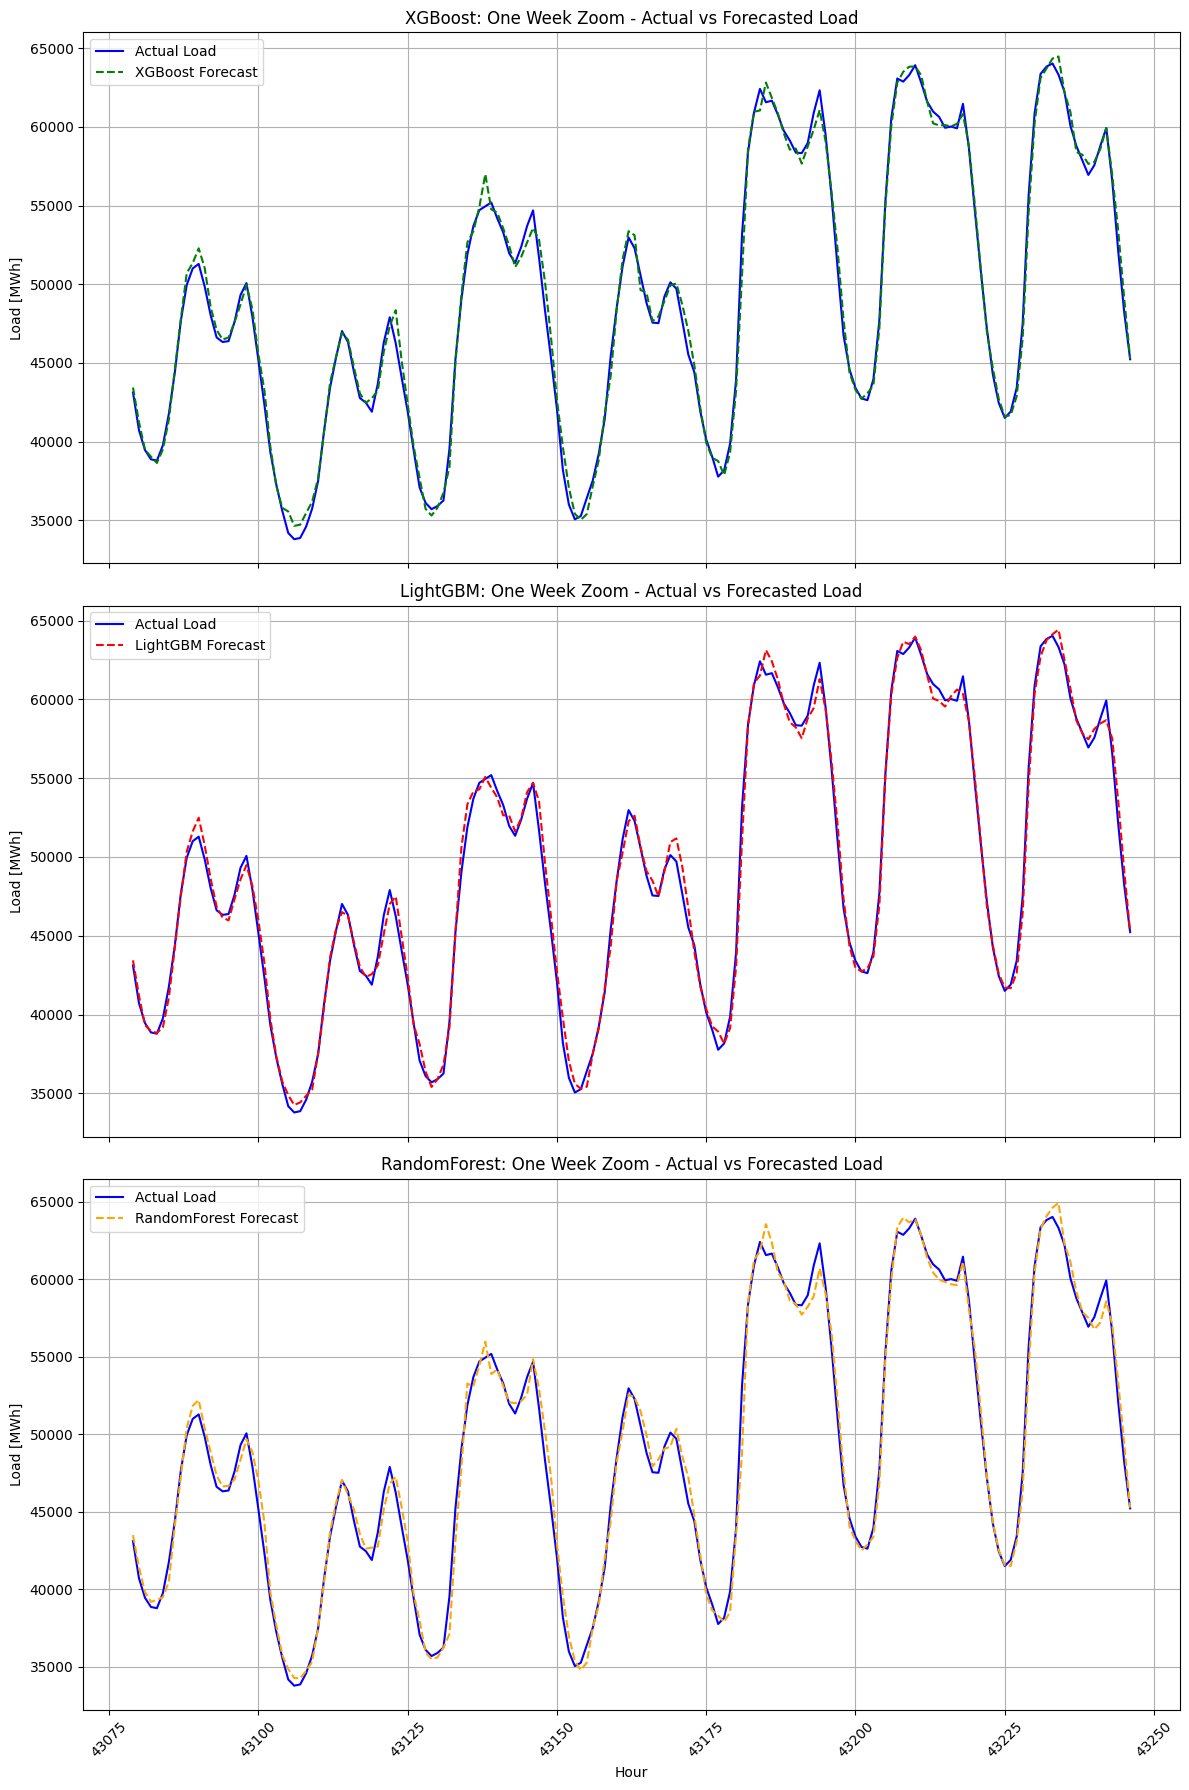

In [10]:

# Create zoomed-in plots for one week
# Select first week of data (168 hours = 1 week)
start_idx = 0
end_idx = 168  # Assuming hourly data: 24 hours * 7 days
mask = y_test.index[(y_test.index >= start_idx) & (y_test.index < end_idx)]

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# XGBoost zoomed plot
axes[0].plot(y_test.index[0:end_idx], y_test[0:end_idx], label='Actual Load', color='blue')
axes[0].plot(y_test.index[0:end_idx], xgboost_pred[0:end_idx], label='XGBoost Forecast', color='green', linestyle='--')
axes[0].set_title('XGBoost: One Week Zoom - Actual vs Forecasted Load')
axes[0].set_ylabel('Load [MWh]')
axes[0].legend()
axes[0].grid(True)

# LightGBM zoomed plot
axes[1].plot(y_test.index[0:end_idx], y_test[0:end_idx], label='Actual Load', color='blue')
axes[1].plot(y_test.index[0:end_idx], lightgbm_pred[0:end_idx], label='LightGBM Forecast', color='red', linestyle='--')
axes[1].set_title('LightGBM: One Week Zoom - Actual vs Forecasted Load')
axes[1].set_ylabel('Load [MWh]')
axes[1].legend()
axes[1].grid(True)

# RandomForest zoomed plot
axes[2].plot(y_test.index[0:end_idx], y_test[0:end_idx], label='Actual Load', color='blue')
axes[2].plot(y_test.index[0:end_idx], randomforest_pred[0:end_idx], label='RandomForest Forecast', color='orange', linestyle='--')
axes[2].set_title('RandomForest: One Week Zoom - Actual vs Forecasted Load')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Load [MWh]')
axes[2].legend()
axes[2].grid(True)

# Adjust layout for zoomed plots
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()